<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/kitti_interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image matching with Kitti raw dataset
paper: http://users.cecs.anu.edu.au/~hongdong/ECCV_16_matching.pdf

Download Dataset: <br>
Kitti raw dataset 28 different drivings of stereo recording in CITY category. In total, there are contains 56 video sequences of 28 stereo drivings. We are downloading only 4 stereo driving recordings of of 8 video sequences for this experiment<br>
Src: https://www.cvlibs.net/datasets/kitti/raw_data.php?type=city

In [1]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_28_drive_0001/2011_09_28_drive_0001_sync.zip
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0017/2011_09_26_drive_0017_sync.zip
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0048/2011_09_26_drive_0048_sync.zip
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0060/2011_09_26_drive_0060_sync.zip

--2022-11-05 02:31:29--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_28_drive_0001/2011_09_28_drive_0001_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.170.17
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.170.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 424412944 (405M) [application/zip]
Saving to: ‘2011_09_28_drive_0001_sync.zip’

2011_09_28_drive_00 100%[===================>] 404.75M  21.3MB/s    in 20s     

2022-11-05 02:31:49 (20.6 MB/s) - ‘2011_09_28_drive_0001_sync.zip’ saved [424412944/424412944]

--2022-11-05 02:31:49--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0017/2011_09_26_drive_0017_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.46.103
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.46.103|:443... connected.
HTTP request sent, awa

Unzip the data and organize all the video sequences into the new directory 'kitti_raw/data' 

In [2]:
!mkdir kitti_raw
!mkdir kitti_raw/data
!unzip -q 2011_09_28_drive_0001_sync.zip -d kitti_raw
!unzip -q 2011_09_26_drive_0017_sync.zip -d kitti_raw
!unzip -q 2011_09_26_drive_0048_sync.zip -d kitti_raw
!unzip -q 2011_09_26_drive_0060_sync.zip -d kitti_raw

!mkdir kitti_raw/data
!mv kitti_raw/2011_09_26/*  kitti_raw/data
!mv kitti_raw/2011_09_28/*  kitti_raw/data

!rm -rf kitti_raw/2011_09_26
!rm -rf kitti_raw/2011_09_28

mkdir: cannot create directory ‘kitti_raw/data’: File exists


Installations:

In [3]:
!pip -q install torchmetrics

     |████████████████████████████████| 529 kB 15.5 MB/s 


Arguments:

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import sys
import argparse
import numpy as np
import matplotlib.pyplot as plt

def seed_everything(seed=42):
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_args():
    parser = argparse.ArgumentParser(description='Kitti Interpolation Training')
    parser.add_argument('--lr', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--batch_size', default=64, type=int, help='batch size')
    parser.add_argument('--valid_batch_size', default=128, type=int, help='batch size')
    parser.add_argument('--max_epochs', default=100, type=int, help='epoch number')
    parser.add_argument('--ckpt', type=str, default='best_model.pth.tar', help='total gpu')
    parser.add_argument('--criterion', type=str, default='bce', help='total gpu')

    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    return args

Create Dataloader:

Sample size- Train:264, Valid: 360
input: torch.Size([6, 128, 384]) label: torch.Size([3, 128, 384])


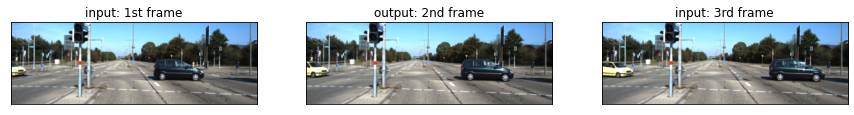

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
from glob import glob
import matplotlib.pyplot as plt

class Kitti_dataset(Dataset):

    def __init__(self, root=None, sequences=None, transform=None):
        self.transform = transform
        self.triplet_dirs_all = []
        for seq in sequences:
            for mono_folder in ['image_02', 'image_03']:
                full_dir = os.path.join(root, seq, mono_folder, 'data/*.png')
                sorted_dirs = sorted(glob(full_dir))
                for idx in range(len(sorted_dirs[:-2])):
                    triplet_dirs = [sorted_dirs[idx], sorted_dirs[idx + 1], sorted_dirs[idx + 2]]
                    self.triplet_dirs_all.append(triplet_dirs)

    def __len__(self):
        return len(self.triplet_dirs_all)

    def __getitem__(self, index):
        img1 = Image.open(self.triplet_dirs_all[index][0]).convert('RGB')
        img2 = Image.open(self.triplet_dirs_all[index][1]).convert('RGB')
        img3 = Image.open(self.triplet_dirs_all[index][2]).convert('RGB')
        if self.transform:
            img1, img2, img3 = self.transform(img1), self.transform(img2), self.transform(img3)
        input = torch.concat([img1, img3])
        return input, img2


transform_all = transforms.Compose([
    transforms.Resize((128, 384)),
    transforms.ToTensor(),
])

args = get_args()
root = 'kitti_raw/data'
sequences_train = ['2011_09_26_drive_0017_sync', '2011_09_26_drive_0048_sync']
sequences_valid = ['2011_09_28_drive_0001_sync', '2011_09_26_drive_0060_sync']

train_dataset = Kitti_dataset(root=root, sequences=sequences_train, transform=transform_all)
valid_dataset = Kitti_dataset(root=root, sequences=sequences_valid, transform=transform_all)

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=args.valid_batch_size, shuffle=False, num_workers=2)

print("Sample size- Train:%d, Valid: %d"%(len(train_dataset), len(valid_dataset)))

(input, label) = train_dataset[0]
print('input:', input.shape, 'label:', label.shape)
num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(input[:3].permute(1,2,0))
ax[0].set_title('input: 1st frame')

ax[1].imshow(label.permute(1,2,0))
ax[1].set_title('output: 2nd frame')

ax[2].imshow(input[3:].permute(1,2,0))
ax[2].set_title('input: 3rd frame');

Loss functions:

In [6]:
import torch
import math
import torch.nn.functional as F
import numpy as np
from torch import nn
from torchmetrics import StructuralSimilarityIndexMeasure

class SSIM_Loss_Lib(nn.Module):
    def __init__(self, data_range=1):
        super().__init__()
        self.ssim = StructuralSimilarityIndexMeasure(data_range=data_range)

    def forward(self, img1, img2):
        return 1 - self.ssim(img1, img2)

Training:

In [7]:
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics import StructuralSimilarityIndexMeasure
import torchvision.transforms as transforms
from PIL import Image
import os
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train(model, trainloader, optimizer, criterion):
    model.train()
    for i_batch, s_batch in enumerate(trainloader):
        image_batch, label_batch = s_batch[0].to(device), s_batch[1].to(device)
        outputs = model(image_batch)
        loss = criterion(outputs, label_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(model, testloader):
    model.eval()
    ssim = StructuralSimilarityIndexMeasure(data_range=1)
    mse_all = []
    ssim_all = []
    with torch.no_grad():
        for i_batch, s_batch in enumerate(testloader):
            image_batch, label_batch = s_batch[0].to(device), s_batch[1].to(device)
            outputs = model(image_batch)
            #outputs = nn.Sigmoid()(outputs)
            mse = nn.MSELoss()(outputs, label_batch)
            mse_all.append(mse.item())
            ssim_all.append(ssim(outputs.detach().cpu(), label_batch.detach().cpu()).item())
        return np.mean(mse_all), np.mean(ssim_all)

def main():
    seed_everything()
    args = get_args()

    root = 'kitti_raw/data'
    sequences_train = ['2011_09_26_drive_0017_sync', '2011_09_26_drive_0048_sync']
    sequences_valid = ['2011_09_28_drive_0001_sync', '2011_09_26_drive_0060_sync']

    train_dataset = Kitti_dataset(root=root, sequences=sequences_train, transform=transform_all)
    valid_dataset = Kitti_dataset(root=root, sequences=sequences_valid, transform=transform_all)

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=args.valid_batch_size, shuffle=False, num_workers=2)

    print("Sample size- Train:%d, Valid: %d"%(len(train_dataset), len(valid_dataset)))
    #github: https://github.com/mateuszbuda/brain-segmentation-pytorch/blob/master/unet.py
    model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
            in_channels=6, out_channels=3, init_features=32, pretrained=False)
    # model.encoder1.enc1conv1 = nn.Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    # model.conv = nn.Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1))
    model.to(device)

    if args.criterion == 'mse':        
        criterion = nn.MSELoss().to(device)
    elif args.criterion == 'l1':        
        criterion = nn.L1Loss().to(device)
    elif args.criterion == 'ssim':        
        criterion = SSIM_Loss_Lib(data_range=1.0).to(device)
    elif args.criterion == 'bce':
        criterion = nn.BCELoss().to(device)

    
    #optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=0.0001)
    optimizer = optim.AdamW(model.parameters(), lr=args.lr)
    criterion = nn.BCELoss().to(device)
    best_mse, best_ssim, best_epoch = np.inf, 0, 0
    for epoch_num in range(args.max_epochs):
        train(model, train_loader, optimizer, criterion)
        mse, ssim = test(model, valid_loader)
        if mse < best_mse:
            best_mse = mse
            best_ssim = ssim
            best_epoch = epoch_num
            torch.save(model.state_dict(), args.ckpt)
            
        print('Epoch:{}, Curr MSE(L2):{:.6f}, Best MSE(L2):{:.6f}, Best SSIM:{:.6f}, Best Epoch:{}, Criterion:{}, Lr:{}'.
                format(epoch_num, mse, best_mse, best_ssim, best_epoch, args.criterion, optimizer.param_groups[0]['lr']))

# if __name__ == "__main__":
#     main()

#Qualitative Performance:<br>
download trained weights

In [10]:
#https://drive.google.com/file/d/1YeP83VDRjmi0s-vblpRjMIgi888wNzXk/view?usp=sharing
import gdown
url = 'https://drive.google.com/uc?id=1YeP83VDRjmi0s-vblpRjMIgi888wNzXk'
gdown.download(url,'best_model.pth.tar',quiet=True)

'best_model.pth.tar'

Check the performance:

In [29]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
            in_channels=6, out_channels=3, init_features=32, pretrained=False)
model.load_state_dict(torch.load('best_model.pth.tar'))
model.cuda()

mse, ssim = test(model, valid_loader)
print('MSE(L2):{:.6f}, SSIM:{:.6f}'.format(mse, ssim))

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


MSE(L2):0.007379, SSIM:0.773525


Prediction Visualization:

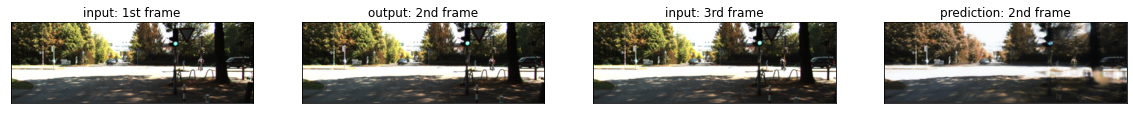

In [31]:
(input, label) = valid_dataset[10]
prediction = model(input[None].cuda())

num_img = 4
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(input[:3].permute(1,2,0))
ax[0].set_title('input: 1st frame')

ax[1].imshow(label.permute(1,2,0))
ax[1].set_title('output: 2nd frame')

ax[2].imshow(input[3:].permute(1,2,0))
ax[2].set_title('input: 3rd frame');

ax[3].imshow(prediction[0].detach().cpu().permute(1,2,0))
ax[3].set_title('prediction: 2nd frame');

#Gradient calculation 
According to paper: raster_grid = 4x4<br>
change the pixel(i, j) in interpolation to get correspondance for any desire pixels

In [26]:
import torchvision.transforms as transforms

model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
            in_channels=6, out_channels=3, init_features=32, pretrained=False)
model.load_state_dict(torch.load('best_model.pth.tar'))
model.cuda()
model.eval()
(input, label) = valid_dataset[10]
input = input.cuda()

#Pointing gradient for input so that backward pass generate the gradient for the inputs too
input = torch.nn.Parameter(input)
prediction = model(input[None])

#As sigmoid was built-in with UNet, reversing sigmoid to get the logits
logits = torch.log(prediction/(1-prediction))

#creating raster grid as paper
[c, h, w] = logits[0].shape 
raster_grid = torch.ones((3, 4, 4))
target_to_gradient= torch.zeros(logits.shape).cuda()

#define pixel in interpolated image to find the correspondences
i = 90
j = 80
target_to_gradient[:,:,i:i+4, j:j+4] = raster_grid
target_to_gradient = target_to_gradient.cuda()

#Main command to generate gradient for the corresponding predicted class or pixels
logits.backward(target_to_gradient, retain_graph=True)
input_grad = input.grad.data.cpu()

#Spliting gradient into frame 1 and frame 3 and converting to gray scale as paper 
rgb2gray = transforms.Grayscale(num_output_channels=1)
input_grad_img1 = rgb2gray(input_grad[:3,])
input_grad_img2 = rgb2gray(input_grad[3:,])

#finding pixels of the maximum gradient in the generated input gradient for both frames
correspondence_img1 = (input_grad_img1==torch.max(input_grad_img1)).nonzero()[0]
correspondence_img2 = (input_grad_img2==torch.max(input_grad_img2)).nonzero()[0]
print('pixel in interpolated image:', i+1, j+1)
print('correspondence in img1:', correspondence_img1[1:])
print('correspondence in img2:', correspondence_img2[1:])

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


pixel in interpolated image: 91 81
correspondence in img1: tensor([93, 83])
correspondence in img2: tensor([91, 82])


Visualizing correspondences

Text(0.5, 1.0, 'Gradient: 3rd frame')

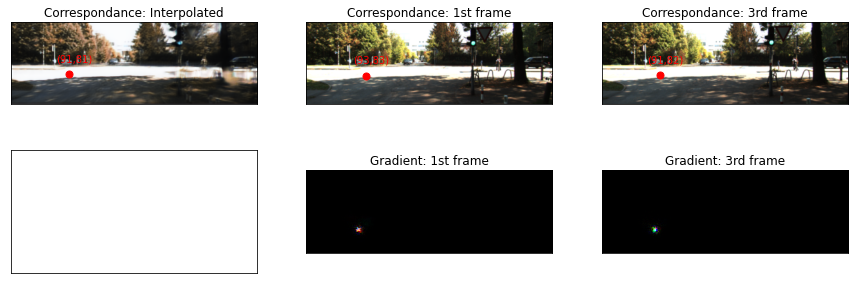

In [27]:
import matplotlib.patches as patches

input = input.detach().cpu()
num_img = 3
fig, ax = plt.subplots(2, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))

ax[0,0].imshow(prediction[0].detach().cpu().permute(1,2,0))
ax[0,0].plot(i+1, j+1, 'o', markersize=7, color='r')
text= '({},{})'.format(i+1, j+1)
ax[0,0].text(i+1-20, j+1-20, text, color='r')
ax[0,0].set_title('Correspondance: Interpolated')

ax[0,1].imshow(input[:3].permute(1,2,0))
ax[0,1].plot(correspondence_img1[1], correspondence_img1[2], 'o', markersize=7, color='r')
text= '({},{})'.format(correspondence_img1[1], correspondence_img1[2])
ax[0,1].text(correspondence_img1[1]-20, correspondence_img1[2]-20, text, color='r')
ax[0,1].set_title('Correspondance: 1st frame')

ax[0,2].imshow(input[3:].permute(1,2,0))
ax[0,2].plot(correspondence_img2[1], correspondence_img2[2], 'o', markersize=7, color='r')
text= '({},{})'.format(correspondence_img2[1], correspondence_img2[2])
ax[0,2].text(correspondence_img2[1]-20, correspondence_img2[2]-20, text, color='r')
ax[0,2].set_title('Correspondance: 3rd frame');

ax[1,1].imshow(input_grad[:3,].permute(1,2,0))
ax[1,1].set_title('Gradient: 1st frame')

ax[1,2].imshow(input_grad[3:,].permute(1,2,0))
ax[1,2].set_title('Gradient: 3rd frame')